TokaMaker Example: Reconstruction with eddy current modes in LTX {#doc_tMaker_LTX_ex3}
==========
In this example we show how eddy current patterns can be included in reconstructions of LTX-&beta;, including:
 1. Computing characteristic eddy current modes for the VV and Shell and adding them to the equilibrium as coil-like free parameters
 2. Constraining an inverse equilibrium with flux measurements
 3. Performing a full reconstruction

This example utilizes the mesh built in \ref doc_tMaker_LTX_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import time
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_spline_flux_fun

## Compute eddy current modes

First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

Then we load the mesh generated in \ref doc_tMaker_LTX_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh()".

In [3]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('LTX_mesh.h5')
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_eddy_modes
Revision id:          c435b10
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Compute eddy current modes for the VV
Now we build a model of LTX-$\beta$ where the resistivity in the shell is increased to isolate eddy currents in the VV. To do this we copy the `cond_dict` object loaded above and modify the `eta` values for the two shell regions.

Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()" to define the different region types and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
cond_dict_vv = copy.deepcopy(cond_dict)
cond_dict_vv['SHELLU']['eta']=1.E2
cond_dict_vv['SHELLL']['eta']=1.E2
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict_vv,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3211
    # of edges   =    9490
    # of cells   =    6280
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.318E-02
    hmax =  7.276E-02
  Surface grounded at vertex     649


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.4829999999999999E-003


With the model setup we can now compute the characteristic eigenmodes of the VV conductors, which we save to use as part of our eddy current mode basis later on.

Longest L/R time = 4.3353E-03 [s]


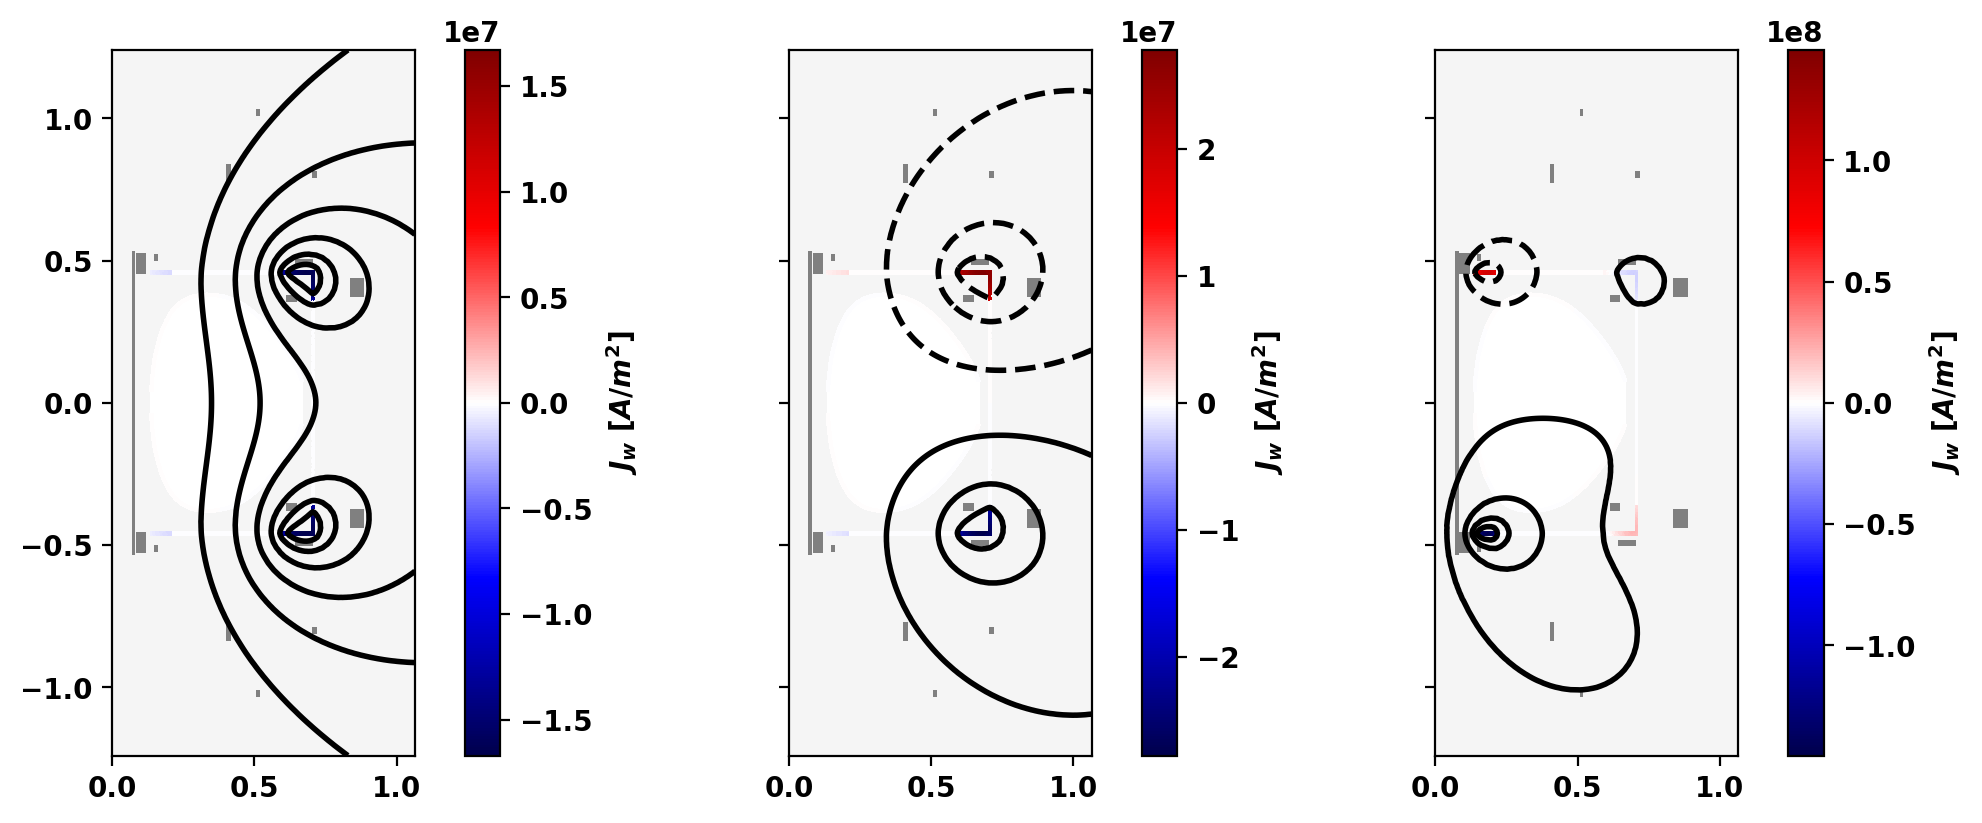

In [5]:
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
for i in range(3):
    mygs.plot_machine(fig,ax[i],limiter_color=None)
    mygs.plot_psi(fig,ax[i],eig_vecs[i,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
    mygs.plot_eddy(fig,ax[i],dpsi_dt=eig_vecs[i,:]*abs(eig_vals[i,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))
vv_eigs = eig_vecs.copy()

### Setup normal LTX-$\beta$ model
Now we reset the TokaMaker object and rebuild the model using the original `cond_dict` definitions.

In [6]:
mygs.reset()
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3211
    # of edges   =    9490
    # of cells   =    6280
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.318E-02
    hmax =  7.276E-02
  Surface grounded at vertex     649


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.3720000000000000E-003


With the new model setup we can now compute the characteristic eigenmodes of the Shell+VV conductors, which is dominated by the shell due to its low resistivity.

Longest L/R time = 5.1504E-03 [s]


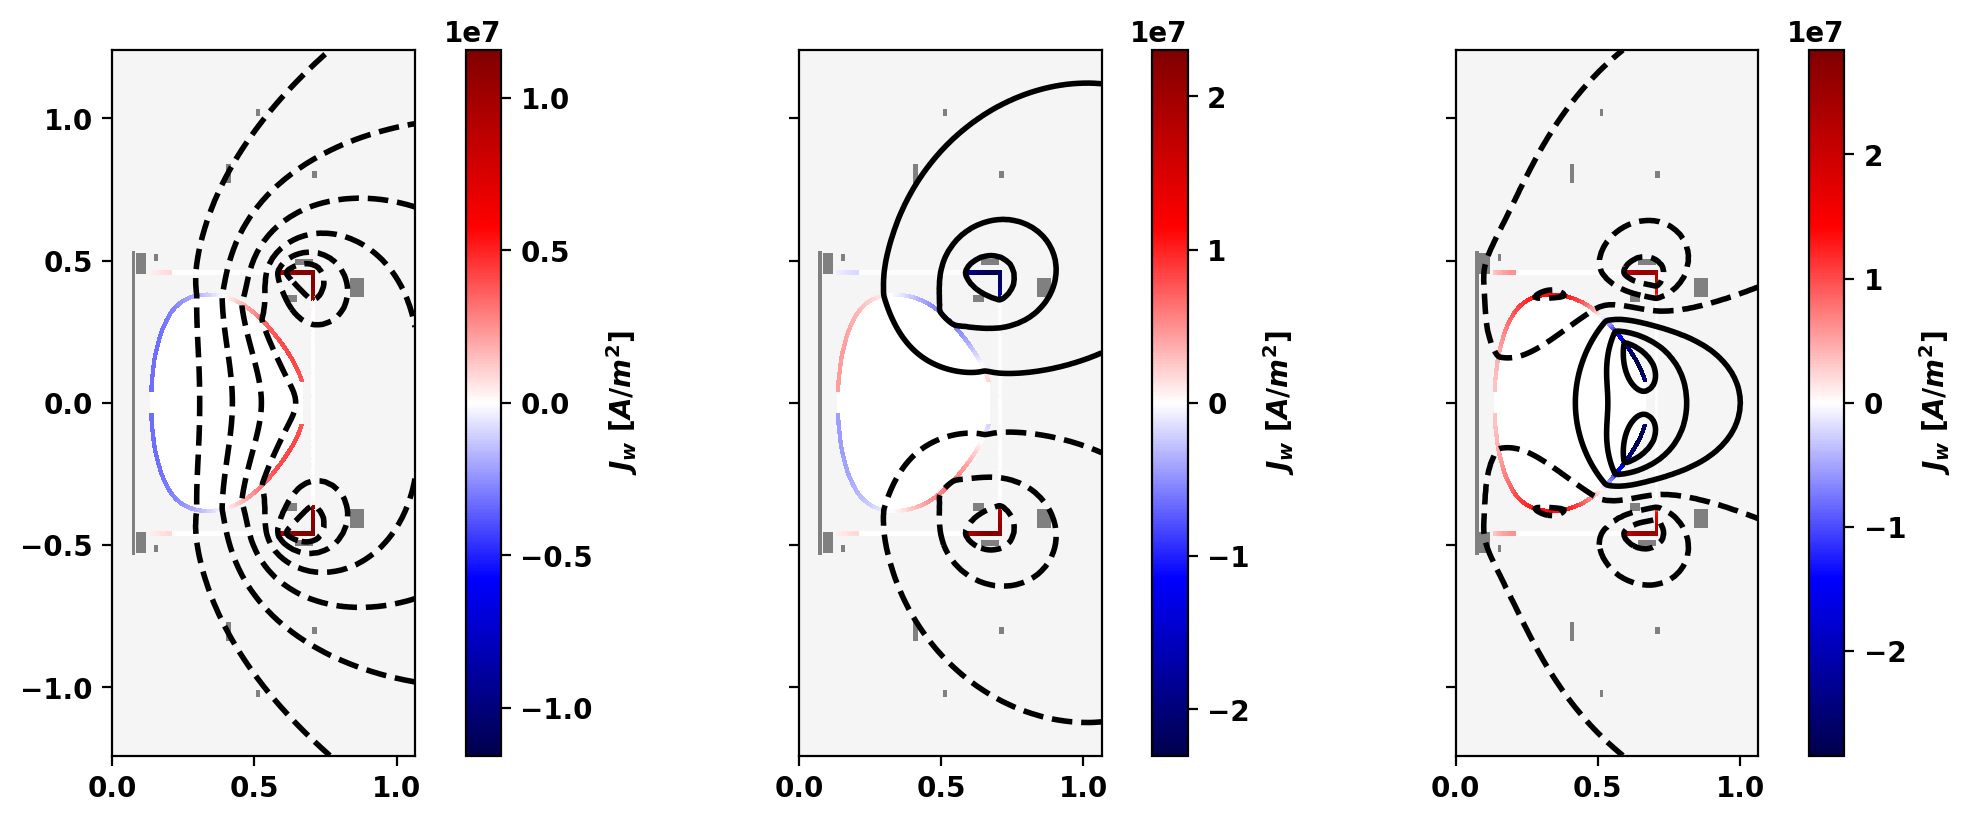

In [7]:
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
for i in range(3):
    mygs.plot_machine(fig,ax[i],limiter_color=None)
    mygs.plot_psi(fig,ax[i],eig_vecs[i,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
    mygs.plot_eddy(fig,ax[i],dpsi_dt=eig_vecs[i,:]*abs(eig_vals[i,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))

### Define eddy current basis
We now build an eddy current mode basis from the longest-lived shell+VV mode and the 1st and 3rd longest-lived VV modes. Then we add these modes to the model using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_cond_modes "set_cond_modes()". Once added these modes can now contribute to inverse equilibrium solves and reconstructions, by varying their amplitude with fixed current distribution -- similar to how coils work.

In [8]:
neigs = np.zeros((10,),dtype=np.int32)
neigs[0] = 3
cond_eigs = np.vstack((eig_vecs[0,:],vv_eigs[[0,2],:]))
mygs.set_cond_modes(neigs,cond_eigs)

### Finish model setup
As with other LTX-$\beta$ examples we use the "INTERNAL" coils as VSC coils and define a simple cubic flux function, using \ref OpenFUSIONToolkit.TokaMaker.util.create_spline_flux_fun "create_spline_flux_fun()", with the same shape for both F\*F' and P'.

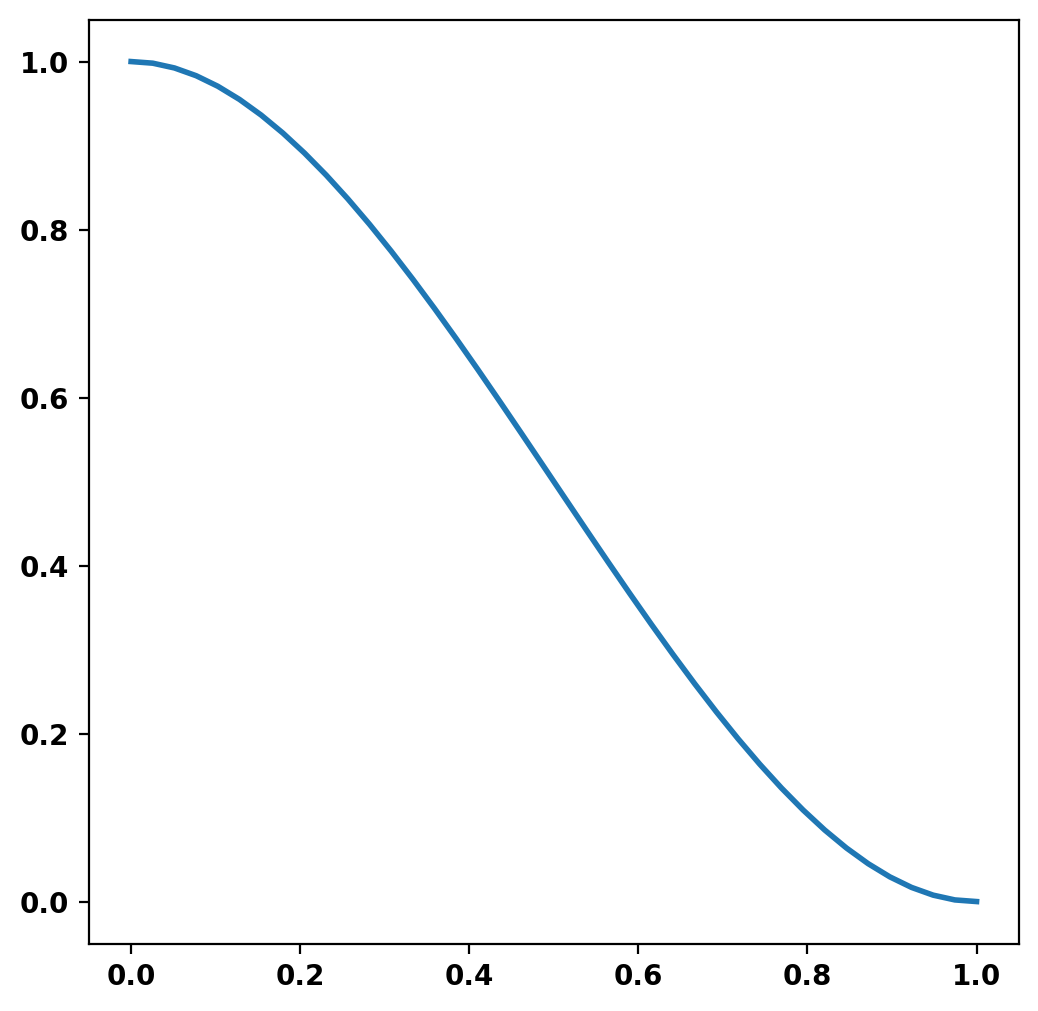

In [9]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[mygs.coil_sets['INTERNALU']['id'], mygs.coil_sets['INTERNALL']['id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

prof = create_spline_flux_fun(40,[0.0,0.5,1.0],[1.0,0.5,0.0],axis_bc=[1,0.0],edge_bc=[1,0.0])
plt.plot(prof['x'],prof['y'])
mygs.set_profiles(ffp_prof=prof,pp_prof=prof)

## Compute inverse equilibrium


In [10]:
with open('LTX_exp_data.json','r') as fid:
    exp_data = json.load(fid)
#
floop_locs = []
floop_vals = []
for floop in exp_data['floops']:
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        floop_locs.append(floop['loc'])
        floop_vals.append(-floop['val'])

In [11]:
# Replace shape constraints with absolute flux and current constraints
mygs.set_isoflux(None)
mygs.set_saddles(None)
mygs.set_targets(Ip=-exp_data['ip'],Ip_ratio=2.0)
mygs.set_flux(np.array(floop_locs),np.array(floop_vals)/2.0/np.pi)

# Set coil regularization to weekly track measured coil currents
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E1*np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))
coil_reg_weights[-1] = 1.E2
for name, coil in mygs.coil_sets.items():
    if name[-1] == 'U' or name[-1] == 'L':
        name = name[:-1]
    coil_reg_targets[coil['id']] = -exp_data['coils'][name.lower()]

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

# Initial equilibrium with very rough guess
err_flag = mygs.init_psi(0.42,0.0,0.15,1.5,0.6)

# Update maximum number of solver iterations
mygs.settings.maxits=100
mygs.settings.urf=0.4
mygs.update_settings()

# Compute initial equilibrium
err_flag = mygs.solve()

Starting non-linear GS solver
     1  6.2865E-01  1.1780E+00  1.3389E-03  4.0342E-01 -7.8765E-03  5.3413E-03
     2  7.4027E-01  1.3541E+00  7.3373E-04  4.0393E-01 -8.9584E-03  9.2275E-03
     3  7.9937E-01  1.4404E+00  4.2103E-04  4.0503E-01 -9.7440E-03  1.1755E-02
     4  8.3389E-01  1.4865E+00  2.6013E-04  4.0623E-01 -1.0383E-02  1.3721E-02
     5  8.5524E-01  1.5120E+00  1.7463E-04  4.0736E-01 -1.0932E-02  1.5376E-02
     6  8.6884E-01  1.5261E+00  1.2640E-04  4.0838E-01 -1.1416E-02  1.6820E-02
     7  8.7768E-01  1.5337E+00  9.7118E-05  4.0927E-01 -1.1850E-02  1.8106E-02
     8  8.8350E-01  1.5375E+00  7.7967E-05  4.0998E-01 -1.2248E-02  1.9265E-02
     9  8.8739E-01  1.5391E+00  6.4555E-05  4.1057E-01 -1.2609E-02  2.0316E-02
    10  8.9001E-01  1.5396E+00  5.4658E-05  4.1106E-01 -1.2938E-02  2.1275E-02
    11  8.9182E-01  1.5395E+00  4.7070E-05  4.1147E-01 -1.3239E-02  2.2153E-02
    12  8.9308E-01  1.5390E+00  4.1060E-05  4.1179E-01 -1.3515E-02  2.2957E-02
    13  8.9397E-01  1.

### Compare flux loop signals

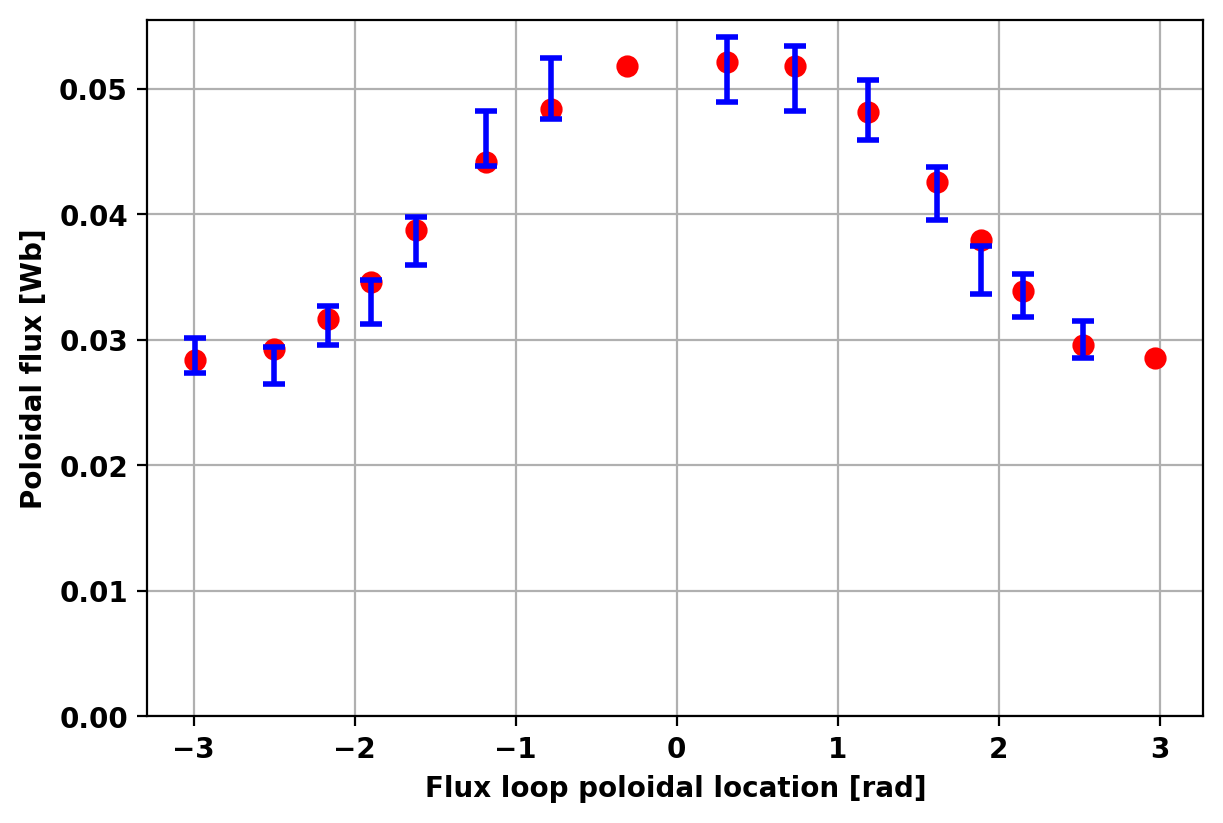

In [12]:
field_eval = mygs.get_field_eval('PSI')
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(6,4))
for floop in exp_data['floops']:
    theta = np.arctan2(floop['loc'][1],floop['loc'][0]-0.42)
    B_tmp = field_eval.eval(floop['loc'])
    if floop['name'].startswith('CENTERSTACK'):
        continue
    ax.plot(theta,-B_tmp[0]*2.0*np.pi,'ro')
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        ax.errorbar(theta,floop['val'],yerr=0.05*abs(B_tmp[0]*2.0*np.pi),color='b',capsize=4)
ax.set_ylim(bottom=0.0)
ax.grid(True)
ax.set_xlabel('Flux loop poloidal location [rad]')
_ = ax.set_ylabel('Poloidal flux [Wb]')

### Plot equilibrium and eddy currents
We now show the updated equilibrium, this time using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" to show the eddy currents in the vessel due to the change in flux from the preceding equilibrium.

Starting CG solver
     0  0.000000E+00  0.000000E+00  3.698603E-01
     1 -5.489790E+02  3.785398E+03  1.797460E-01  4.748405E-05
     2 -6.515252E+02  3.989841E+03  7.404473E-02  1.855831E-05
     3 -6.678983E+02  4.075579E+03  2.591082E-02  6.357579E-06
     4 -6.702956E+02  4.088868E+03  1.089627E-02  2.664861E-06
     5 -6.706307E+02  4.088172E+03  3.771561E-03  9.225542E-07
     6 -6.706788E+02  4.082032E+03  1.463873E-03  3.586138E-07
     7 -6.706869E+02  4.082183E+03  5.641385E-04  1.381953E-07
     8 -6.706879E+02  4.082436E+03  2.716075E-04  6.653074E-08
     9 -6.706882E+02  4.082506E+03  9.414212E-05  2.305989E-08
    10 -6.706882E+02  4.082572E+03  3.251202E-05  7.963612E-09
    20 -6.706882E+02  4.082553E+03  2.371382E-09  5.808576E-13
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.0326E+05
  Current Centroid [m]    =    0.385 -0.017
  Magnetic Axis [m]       =    0.413 -0.017
  Elongation              =    1.189 (U:  1.181

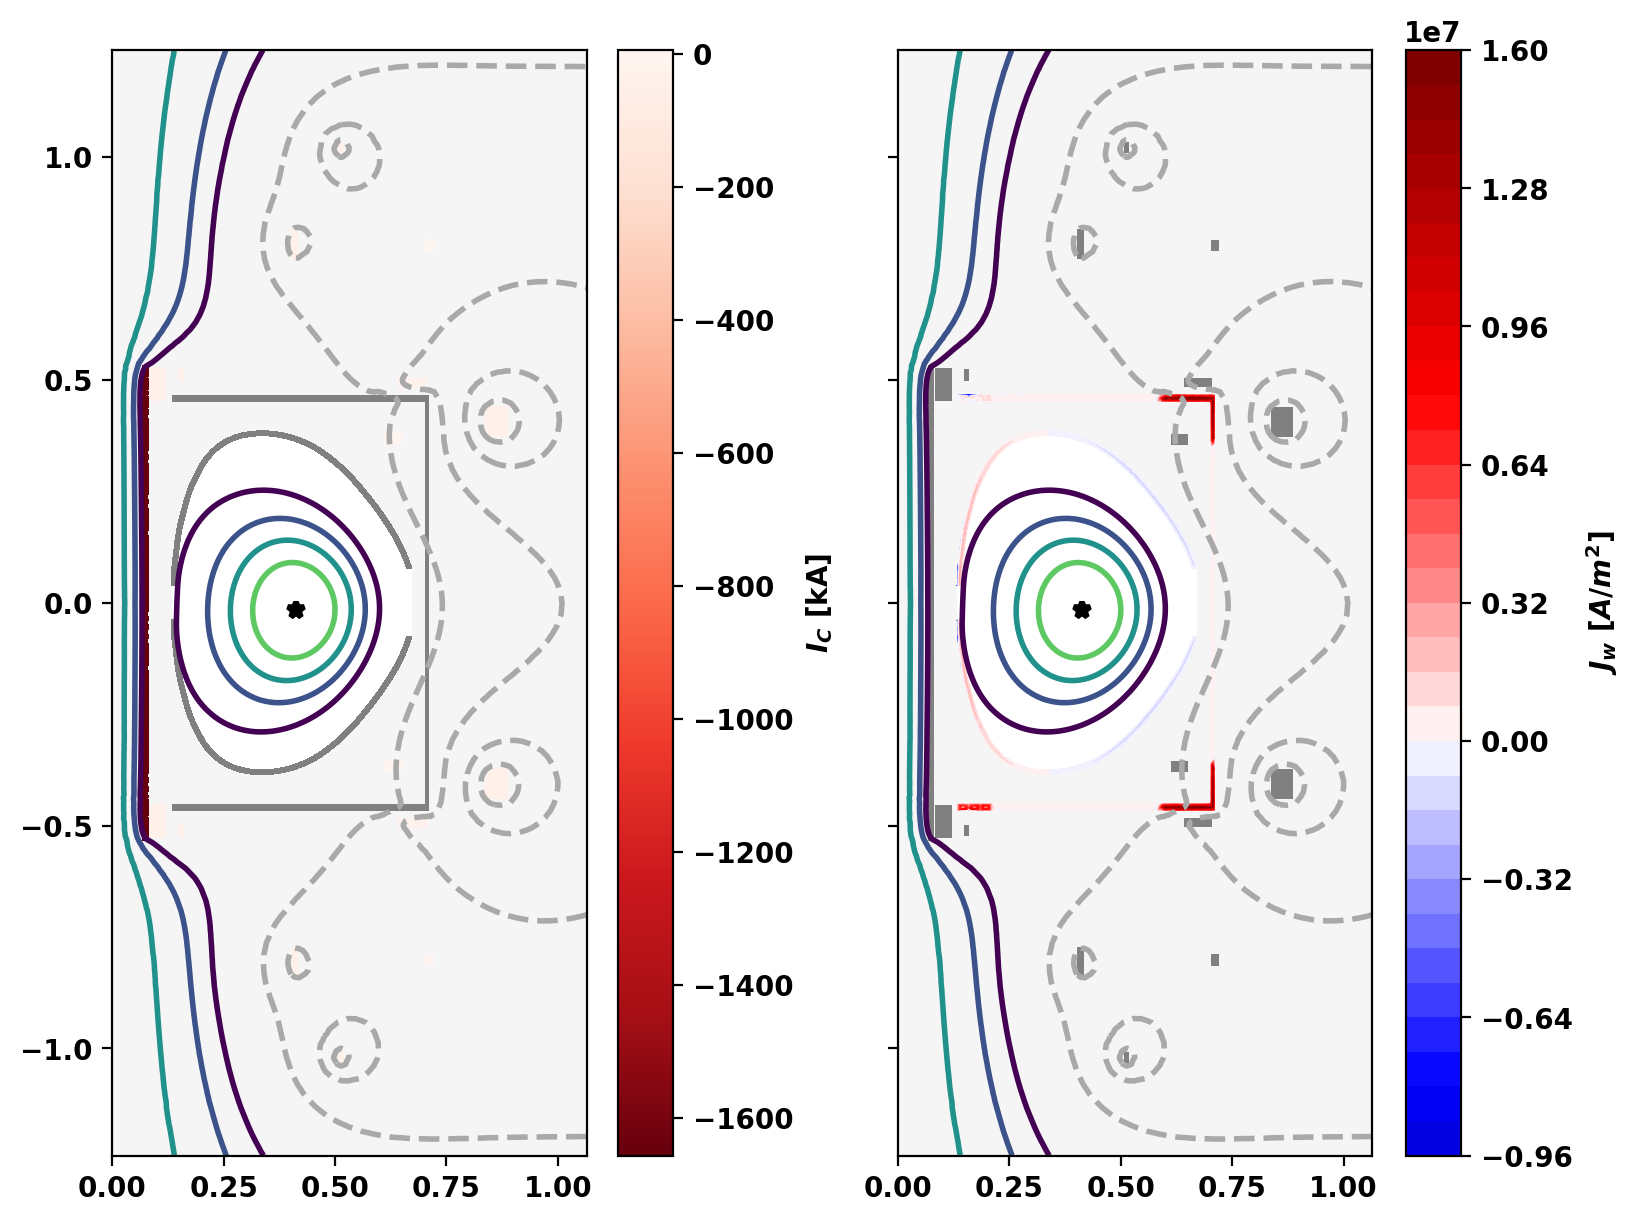

In [13]:
# Plot equilibrium
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(8,6))
mygs.plot_machine(fig,ax[0],coil_colormap='Reds_r',coil_scale=1.E-3,coil_clabel=r'$I_C$ [kA]',limiter_color=None)
mygs.plot_psi(fig,ax[0],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_machine(fig,ax[1],limiter_color=None)
mygs.plot_psi(fig,ax[1],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_eddy(fig,ax[1],psi=mygs.get_psi(False),colormap='seismic',symmap=True)
# Print information and coil currents
mygs.print_info()
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E3))

## Compute equilibrium reconstruction

In [14]:
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction
myrecon = reconstruction(mygs)
for floop in exp_data['floops']:
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        myrecon.add_flux_loop(floop['loc'],-floop['val'], err=abs(floop['val']*0.05))
myrecon.set_Ip(-exp_data['ip'], err=abs(0.05*exp_data['ip']))
myrecon.set_DFlux(exp_data['dflux'], err=abs(0.1*exp_data['dflux']))
myrecon.set_coil_currents(coil_reg_targets[:-1], err=abs(0.05*coil_reg_targets[:-1]))

# Remove all shape constraints
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)

# Set initial position targets from current values
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])

# Set reconstruction settings
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.pm = False

# Perform reconstructions
err_flag = myrecon.reconstruct()


*** Loading fit constraints ***
 Fixed           3           3

Starting Fit:
  # of free parameters   =   18
  # of constraints       =   29

Function evaluation    1
  Alam              =  8.972E-01
  P_scale           =  1.535E+00
  R0_target         =  4.132E-01
  V0_target         = -1.666E-02
  Cond weights      =  2.666E-01  7.207E-01  4.773E-03
  Min/max coil current change [%]  =  -0.000  -0.000
  Maximum Rel Error =  1.294E-01
  Maximum Abs Error =  1.108E+00
  Total Weighted Error   =  2.704E+00
  RMS Weighted Error     =  5.021E-01

Function evaluation    2
  Alam              =  8.972E-01
  P_scale           =  1.535E+00
  R0_target         =  4.132E-01
  V0_target         = -1.666E-02
  Cond weights      =  2.666E-01  7.207E-01  4.773E-03
  Min/max coil current change [%]  =  -0.000  -0.000
  Maximum Rel Error =  1.295E-01
  Maximum Abs Error =  1.129E+00
  Total Weighted Error   =  2.704E+00
  RMS Weighted Error     =  5.021E-01

Gradient evaluation     1

Function eval

### Compare reconstructed values

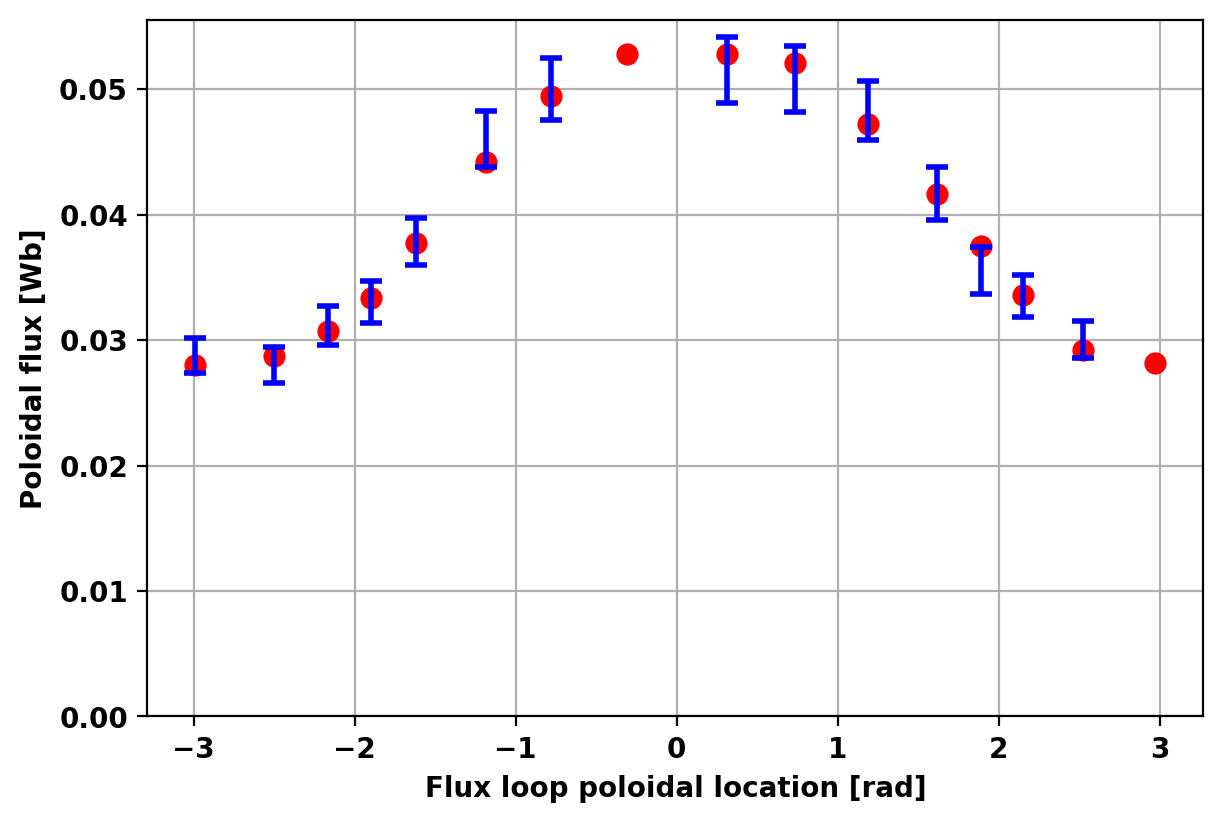

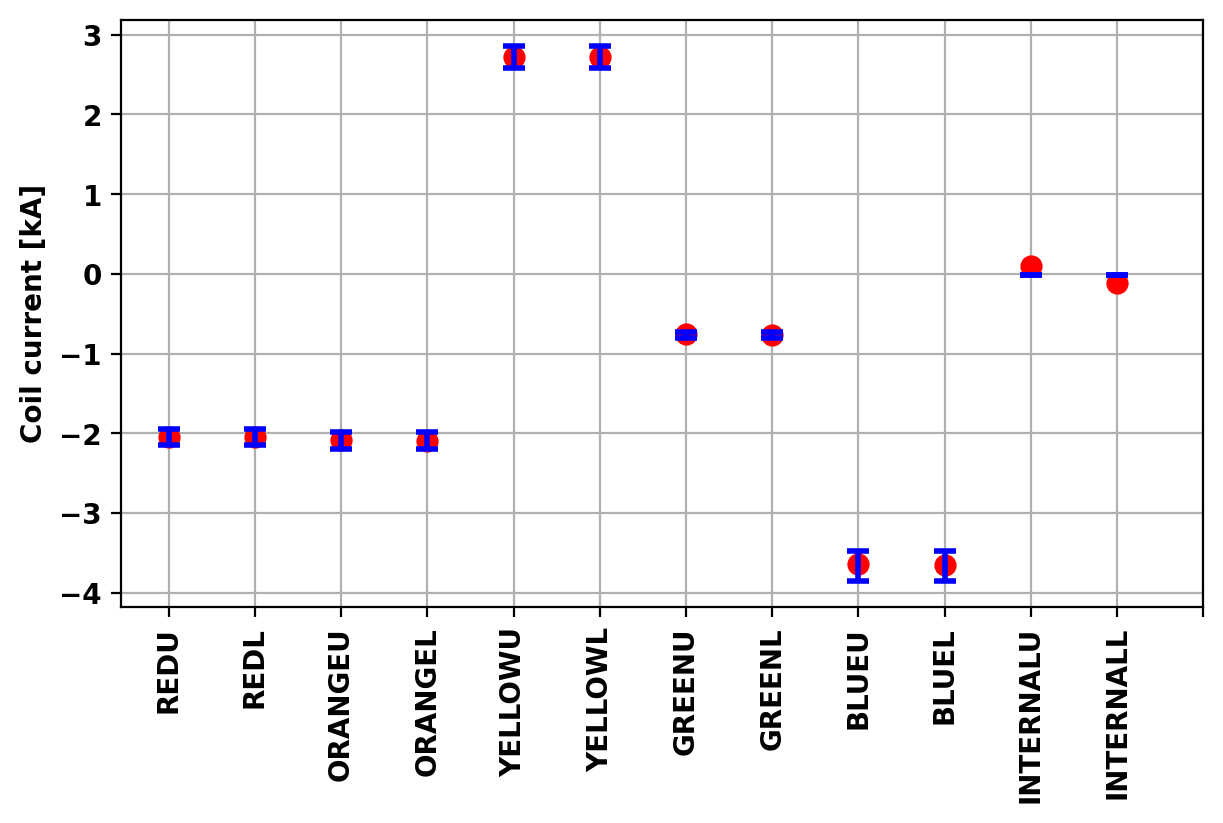

In [15]:
field_eval = mygs.get_field_eval('PSI')
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(6,4))
for floop in exp_data['floops']:
    theta = np.arctan2(floop['loc'][1],floop['loc'][0]-0.42)
    B_tmp = field_eval.eval(floop['loc'])
    if floop['name'].startswith('CENTERSTACK'):
        continue
    ax.plot(theta,-B_tmp[0]*2.0*np.pi,'ro')
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        ax.errorbar(theta,floop['val'],yerr=0.05*abs(B_tmp[0]*2.0*np.pi),color='b',capsize=4)
ax.set_ylim(bottom=0.0)
ax.grid(True)
ax.set_xlabel('Flux loop poloidal location [rad]')
_ = ax.set_ylabel('Poloidal flux [Wb]')

#
coil_currents, _ = mygs.get_coil_currents()
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(6,4))
labels = ['' for _ in range(mygs.ncoils)]
for name, coil in mygs.coil_sets.items():
    if name.startswith('OH'):
        continue
    labels[coil['id']] = name
    ax.plot(coil['id'],coil_currents[coil['id']]/1.E3,'ro')
    ax.errorbar(coil['id'],coil_reg_targets[coil['id']]/1.E3,yerr=0.05*abs(coil_reg_targets[coil['id']])/1.E3,color='b',capsize=4)
ax.grid(True)
ax.set_xticks(range(mygs.ncoils),labels=labels,rotation=90)
_ = ax.set_ylabel('Coil current [kA]')

### Plot equilibrium and eddy currents
We now show the updated equilibrium, this time using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" to show the eddy currents in the vessel due to the change in flux from the preceding equilibrium.

Starting CG solver
     0  0.000000E+00  0.000000E+00  3.711601E-01
     1 -5.532567E+02  3.803693E+03  1.802173E-01  4.737957E-05
     2 -6.565735E+02  4.008251E+03  7.429041E-02  1.853437E-05
     3 -6.730603E+02  4.094150E+03  2.601873E-02  6.355101E-06
     4 -6.754771E+02  4.107416E+03  1.093682E-02  2.662700E-06
     5 -6.758146E+02  4.106720E+03  3.787930E-03  9.223736E-07
     6 -6.758631E+02  4.100540E+03  1.469630E-03  3.583991E-07
     7 -6.758713E+02  4.100687E+03  5.665332E-04  1.381557E-07
     8 -6.758723E+02  4.100942E+03  2.727480E-04  6.650862E-08
     9 -6.758726E+02  4.101013E+03  9.454960E-05  2.305518E-08
    10 -6.758726E+02  4.101080E+03  3.261426E-05  7.952601E-09
    20 -6.758726E+02  4.101061E+03  2.380043E-09  5.803482E-13
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.0526E+05
  Current Centroid [m]    =    0.376 -0.017
  Magnetic Axis [m]       =    0.404 -0.017
  Elongation              =    1.218 (U:  1.203

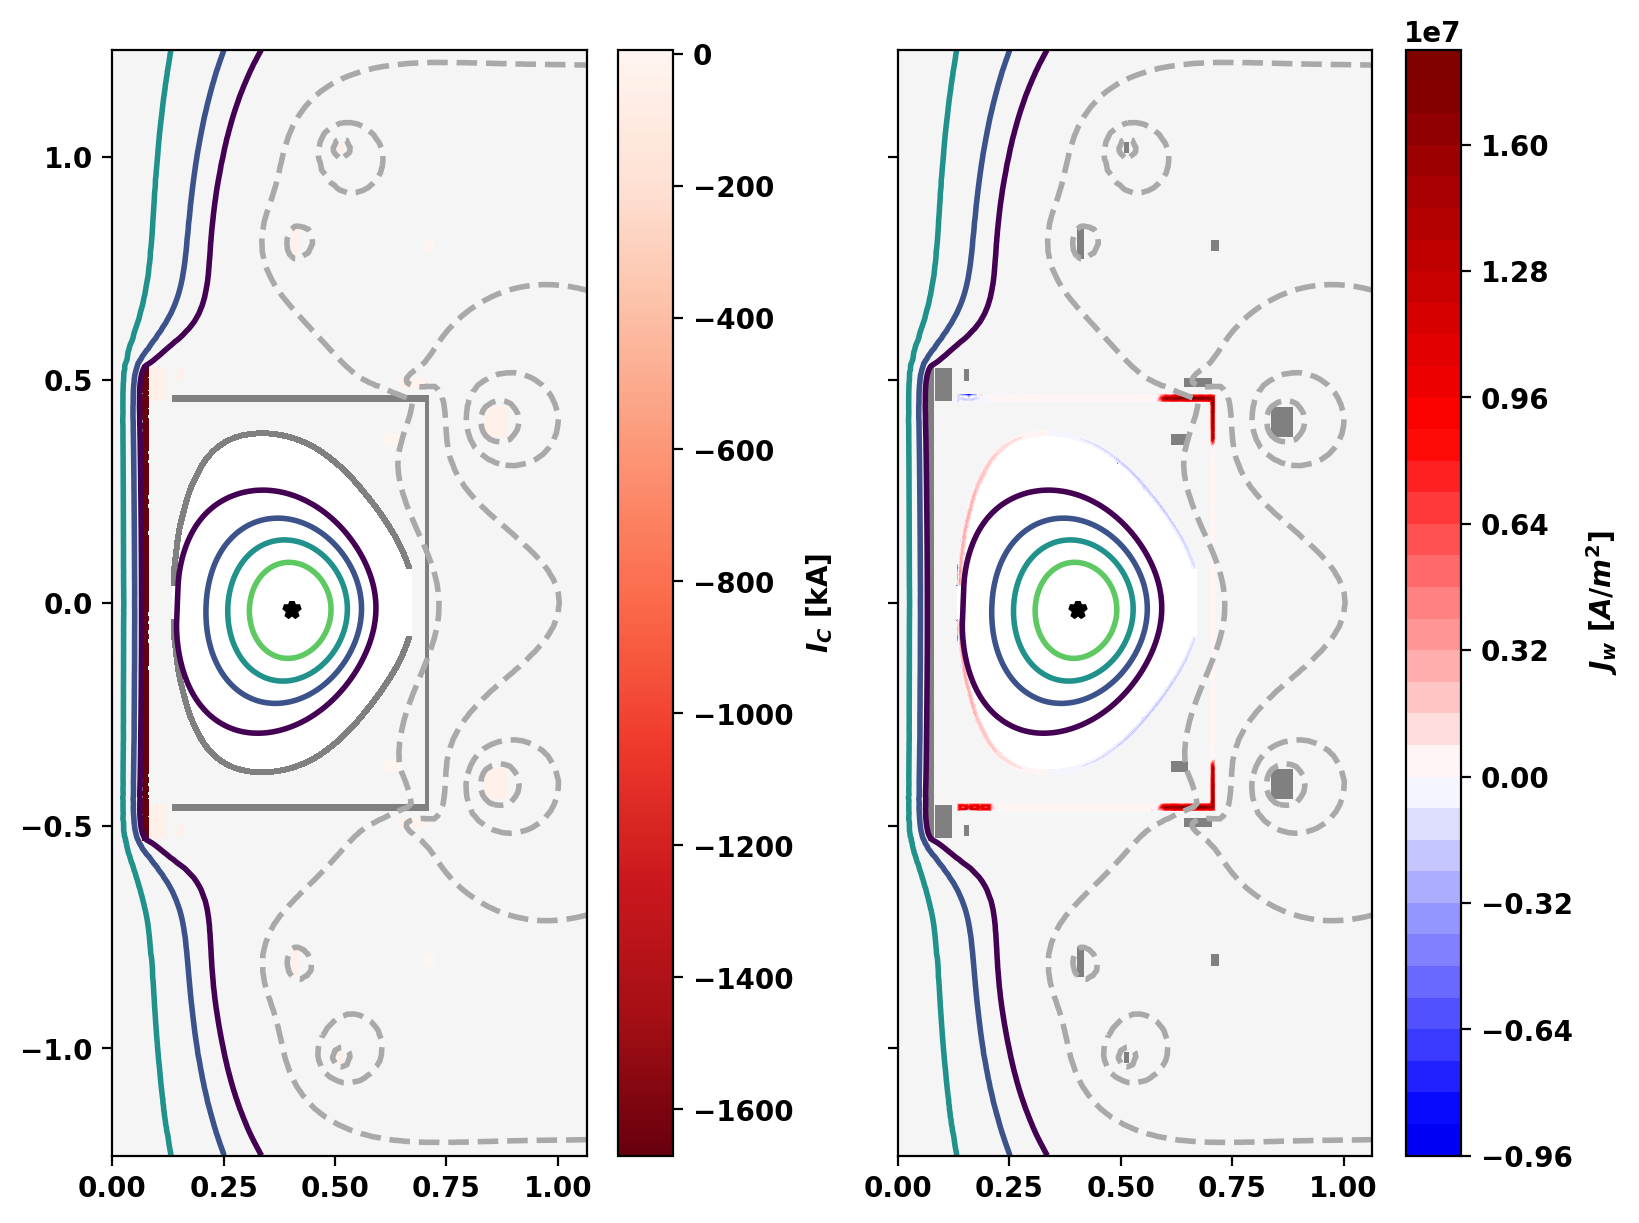

In [16]:
# Plot equilibrium
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(8,6))
mygs.plot_machine(fig,ax[0],coil_colormap='Reds_r',coil_scale=1.E-3,coil_clabel=r'$I_C$ [kA]',limiter_color=None)
mygs.plot_psi(fig,ax[0],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_machine(fig,ax[1],limiter_color=None)
mygs.plot_psi(fig,ax[1],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_eddy(fig,ax[1],psi=mygs.get_psi(False),colormap='seismic',symmap=True)
# Print information and coil currents
mygs.print_info()
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E3))

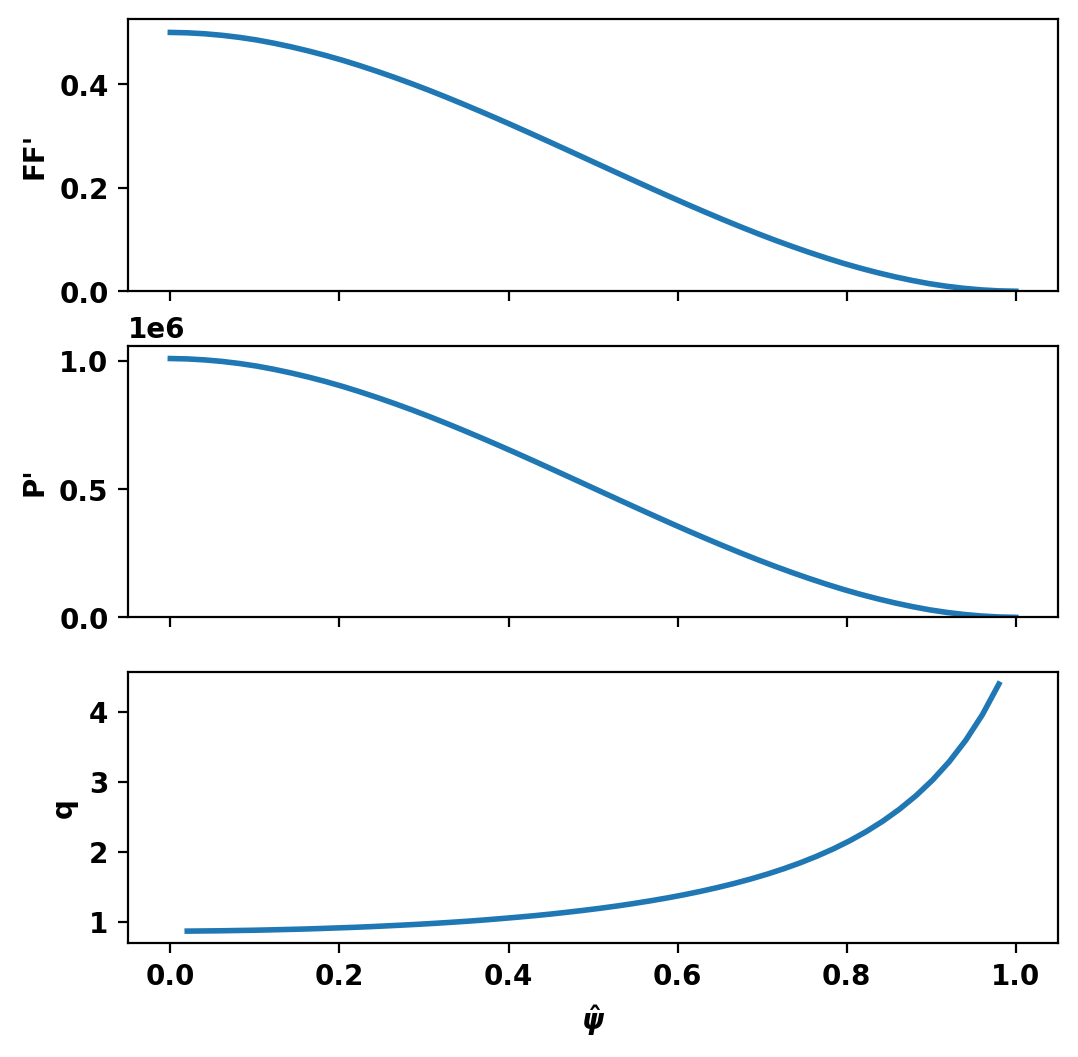

In [17]:
psi,f,fp,p,pp = mygs.get_profiles()
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q()
fig, ax = plt.subplots(3,1,sharex=True)
# Plot F*F'
ax[0].plot(psi,f*fp)
ax[0].set_ylim(bottom=0.0)
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(psi,pp)
ax[1].set_ylim(bottom=0.0)
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")